<table>
  <tr>
      <td><div align="left"><font size="20" >Camera Calibration</font></div></td>
     <td><img src="images/RVSS-logo.png" width="400"></td>
  </tr>
</table>

# Camera calibration

In this notebook we are going to invesitage how we can calibrate a camera to determine the camera's intrinsic and extrinsic parameters. When we calibrate a camera we take an image of a calibration rig and associate certain points/features within that image to real-world coordinates. We can then determine the camera parameters using an optimisation method, for example least-squares.  

Before we dive into real-world data we are going to create a situation where we know the camera parameters, the real-world points and where these points would lie if an image was taken from a specific pose.

In [2]:
%matplotlib notebook
import sys
!{sys.executable} -m pip install machinevision-toolbox-python spatialmath-python # install MVTB and spatialmath

import matplotlib
import ipywidgets as wdg

from machinevisiontoolbox import Image, CentralCamera
import matplotlib.pyplot as plt
import numpy as np
from spatialmath import SE3, SO3
from spatialmath import base

from camera_calib_helpers import CreateSimulatedCamera

np.set_printoptions(linewidth=120, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})



     |████████████████████████████████| 92.2 MB 14 kB/s s eta 0:00:01
     |████████████████████████████████| 127 kB 66.2 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 7.1 MB/s  eta 0:00:01
  Created wheel for machinevision-toolbox-python: filename=machinevision_toolbox_python-0.5.4-py3-none-any.whl size=92172225 sha256=681d47c48cfb3ef0cc92a322059eb443c5e367057d148bc80b07deaa1e8cd638
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e5/a3/78/6f38d9309ff7abfcf5673795ad4b53981bbde23f71532b0fc8
  Created wheel for spatialmath-python: filename=spatialmath_python-0.8.9-py3-none-any.whl size=138273 sha256=9223d9d6370924e91f3f51dbffe317eb63c9fdb8b1ed65ea8cb76bfdeca2c956
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0d/42/c7/c377b6a411f14a016ece6730d944d25b522cedfe088be62e3a
  Created wheel for ansitable: filename=ansitable-0.9.5-py3-none-any.whl size=12174 sha256=be70ee3d21811229c01274d0ddfb12a729940b4fcd34073da32b1aa09431c6ae
  Stored in directory: /home/ec2-

# Calibration Rig

RVSS2021 will be using the following calibration rig which consists of 12 dots forming three 6cm squares on three planes. We will store the real-world 3D coordinates that reflect the markers on the calibration target in the matrix `P_calib`. We will be using `P_calib` throughout this coding session.

![calibration](images/calibration-fixture.png)

In [3]:
cm = 0.01 # centimetre to metre conversion factor

P_calib = np.array([
    [ 0,  -12.2, 12.2],
    [ 0,   -6.2, 12.2],
    [ 0,  -12.2,  6.2],
    [ 0,   -6.2,  6.2],
    [ 6.2,  0,   12.2],
    [12.2,  0,   12.2],
    [ 6.2,  0,    6.2],
    [12.2,  0,    6.2]
]).T * cm

# Calibrating A Simulated Camera

## Simulate a Camera

First, we will simulate a black box camera. While we know the pose and chateristics of this camera (you can check them out in the `CreateSimulatedCamera` function, but we will assume we do not and see if we can find the camera extrinsic and intrinsic parameters ourself using simulated calibration data.


In [4]:
unknown_camera = CreateSimulatedCamera()

principal point not specified,                    setting it to centre of image plane


The object `unknown_camera` is a model of the camera and was computed using the `CreateCameraModel` function in the `camera_calib_helpers.py` script. For now we will pretend we don't know it's characteristics, and that its pose is unknown with respect to the calibration target.

However **we do know** the world coordinates of the markers.

We can create an "artificial" image of the 3D points by projecting these points onto the 2D image plane within our simulated camera, by using the code below. *We can only do this because we know camera characteristics, as well as the pose of the camera and the locations of the 3D points with respect to the world frame.*

creating new figure and axes for camera


<IPython.core.display.Javascript object>


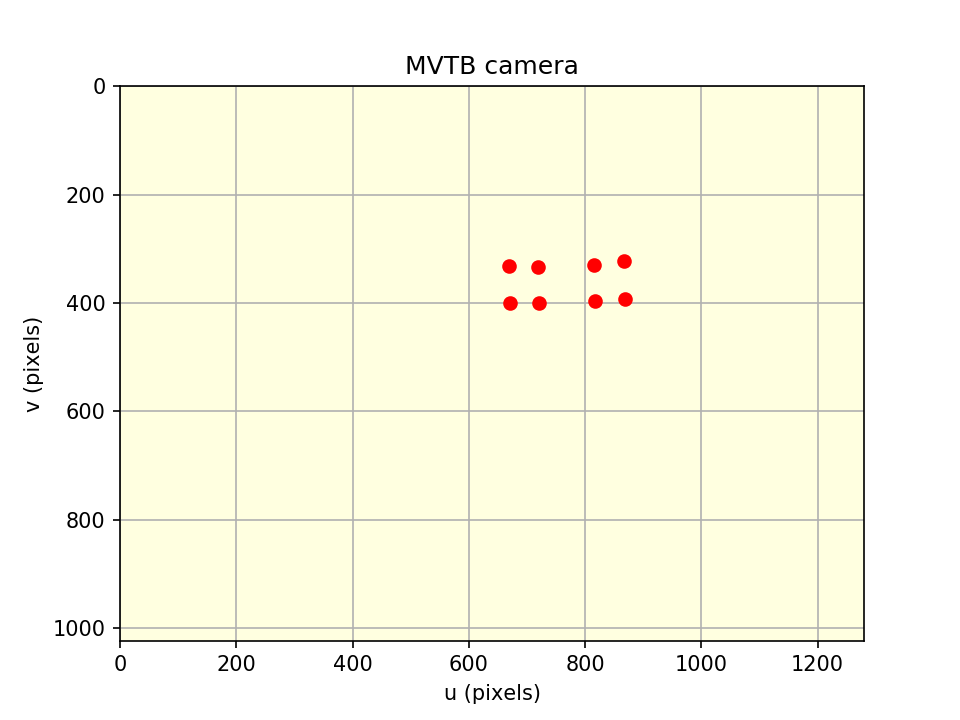

In [5]:
unknown_camera.plot(P_calib)

Projecting the 3D coordinates of the calibration target markers onto the  into 2D image plane coordinates using the camera object's `project` method

In [6]:
p = unknown_camera.project(P_calib)
print(p)

[[   669.3      719    671.6    721.1    815.9    866.2      818    868.3]
 [   331.7    333.6    399.7    399.6    329.5    323.4    395.9    392.1]]


Of course, with real camera calibration these 2D coordinates must be obtained by taking an image and finding the coordinates of the points in the captured image. We will be using a real-image later.

## Compute the Camera Matrix 

We can noe compute the camera calibration from the calibration data, the real-world coordinates `P_calib` and the 2D image coordinates `p`.

 * `P_calib`, is an array of 3D points which is a $3 \times N$ matrix, one point per column (which would be found by measuring the points in the real-world)
 * `p`, is an array of 2D points which is a $2 \times N$ matrix, one point per column (which would be found in the captured image)
    
Importantly, the points correspond, that is the $i^{th}$ column of `p` is the projection of the 3D point in the $i^{th}$ column of `P_calib`.

The camera matrix $C$ can be computed by

In [7]:
C = CentralCamera.camcal(P_calib, p)

residual is 5.22e-11 px


the small residual is an encouraging sign, it indicates that the data is a good fit to the projection model of a perspective camera. *This is to expected in this case as we found `p` by projecting the 3D points using our artificial camera model*

The value of the camera matrix is

In [ ]:
C

The intrinsic and extrinsic parameters of the camera are jumbled up in these 12 numbers, but we can unjumble them

In [ ]:
camera = CentralCamera.invcamcal(C)
print(camera)

The intrinsic and extrinsic parameters have been encapsulated in a toolbox `CentralCamera` object.

**Note:** When computing the camera matrix the focal length and the pixel dimensions are multiplied together, so it's not possible to determine them individually.  This function assumes that the pixel dimension is 1 and the focal length has units of pixels rather than metres (hence the large values).

The intrinsic parameters are

In [ ]:
camera.K

Notice that the values in the top left are half image width and height we specified and that focal length (1500) is a factor of the length we provided into the `CreateSimulatedCamera` function. Naturally, because we are passing in exact data then getting back exact values is to be expected.

The extrinsic parameters, the pose of the camera, with respect to the world calibration frame is

In [ ]:
Tcam = camera.pose
print(Tcam)

This indicates the position of the camera is (1, -1) on the ground plane, and slightly above the ground (z=0.1). Again, this is unsurprising as this is exactly what we passed into the `CreateCameraModel` function.

The orientation of the camera can be found by running

In [ ]:
Tcam.rpy(order='zyx', unit='deg')

which indicates the orientation of the camera obtained is, in order, by:

1. a rotation of 50° about the z-axis, which points the camera toward the calibration target
2. a rotation of 2° about the y-axis, which indicates some imperfection, a small twist about the camera axis
3. a rotation of -92° about the x-axis, which makes the camera's z-axis parallel to the ground plane, again some imperfection so the camera is actually pointing slightly toward the floor.

Again, these values are what we specified in the `CreateCameraModel` and hence what we expect.

That is all that is required to determine the camera charateristics. You simply need two sets of points, one from the real-world and one with the corresponding 2D image coordinates, you need at least 6 corresponding points.

## Mapping Ground Plane Coordinates to the Image Plane

The extrinsic parameters indicate where the camera is with respect to the world frame. Well in many scenarios we want to know the coordinate of a point/object relative to our camera along the ground plane. We define the frame of this ground plane to be directly underneath the camera with the x-axis being forward and the z-axis being upward. We also want to take into account the imperfections in the camera orientation and its height about the ground plane.

The x,y,z position of the camera relative to this ground-plane frame directly below the camera is therefore

In [ ]:
t = [0, 0, Tcam.t[2]] # Tcam.t[2] is the position of the camera in the world frame z-axis
print(t)

The x and y components should always be 0 in fact. The orientation of the camera relative to the ground plane will only consist of the roll and pitch values we originally set. The yaw component will always be zero. Therefore the transform of the camera relative to this ground plane frame, $T$, will be given by

In [ ]:
rpy = Tcam.rpy(order='zyx', unit='deg')
rpy[2] = 0  # set the yaw component to zero
T = SE3(t) * SE3.RPY(rpy, order='zyx', unit='deg')
print(T)

If we set the camera pose to be this transform, then we can determine how points in this ground plane frame would be projected into the image plane. This means we could do the inverse to determine the position of 2D image points in this ground plane.

In [ ]:
camera.pose = T
camera.C

Points on the ground 0.5m and 0.6m in front of the camera appear at the following locations on the image plane

In [ ]:
world_ptns = np.array([[0, 0.5, 0], [0, 0.6, 0]]).T
camera.project(world_ptns)

which are close to u-coordinate of the principal point (640), indicating it close to the centre line.  Remember that the camera is slightly skewed with respect to the world frame.

## Mapping image plane coordinates to the ground plane

In the previous section we intuitively worked through how we can map ground points into the image plane. Now we will see how can we do the opposite, but we will take a more principled approach. 

Points on the ground plane have a z-coordinate of zero.  The camera projection equation, in matrix form, is
$$
\tilde{p} = \begin{pmatrix} c_1 & c_2 & c_3  & c_4 \end{pmatrix} \begin{pmatrix} X \\ Y \\ Z \\ 1 \end{pmatrix}
$$
where $c_i$ is the $i^{th}$ column of the camera matrix.  Since $Z=0$ we can rewrite as 

\begin{align}
\tilde{p} & = \begin{pmatrix} c_1 & c_2 & c_4 \end{pmatrix} \begin{pmatrix} X \\ Y \\ 1 \end{pmatrix} \\
          & = \mathbf{H} \begin{pmatrix} X \\ Y \\ 1 \end{pmatrix}
\end{align}
where $(X, Y)$ is a point on the ground plane with respect to the camera frame which has the Y-axis forward and the X-axis to the right.

In this case $\mathbf{H}$ is

In [ ]:
H = camera.C[:,[0,1,3]]
H

which is both square and non-singular

In [ ]:
np.linalg.det(H)

which means we have an invertible mapping between 2D points in the image plane and 2D points on the ground plane, both expressed in homogenous form.  Such a transformation is called an *homography*.

**Note that in general we cannot map a 2D point to a 3D point, since a 2D image plane coordinate corresponds to a ray in space -- an infinite number of points.  However the constraint that the point lies on the ground plane makes a unique solution possible, it is the point where that ray intersects the ground plane.**

Consider a point in the image plane at $(300, 600)$

In [ ]:
p = (300, 600)  # make homogeneous
P = base.h2e(np.linalg.inv(H) @ base.e2h(p))
print(P)

and if we project that using our camera model

In [ ]:
point = np.r_[P, 0]

# appears to be bug in MVTB toolbox cannot pass in a (3,) or (3,1) array for camera.project
# so we will simply create a copy of the point to make it a (3x2)
pts = np.repeat(point.reshape((3,1)), 2, axis=1) 
camera.project(pts)

we obtain, as we should do, the image plane coordinate we started with.

## Summary

1. Using corresponding 3D and 2D data we can estimate a camera matrix.
2. We can untangle the elements of that matrix into intrinsic and extrinsic parameters.
3. We use an estimated camera model to form an homography which maps between image plane and ground plane.

# Your turn!

Now you get to apply what you've learned above using a real image of a calibration target. The next section of code will display an image and a text widget showing an $8 \times 2$ array. 

You will need to:

1. click the centre of each point as accurately as you can, in the order given by the diagram at the top of this notebook.
2. If you make a mistake, do a right-click and will undo the last point you clicked (and remove the marker)

Once you are happy with the points you selected, move onto the next set of code.

<IPython.core.display.Javascript object>


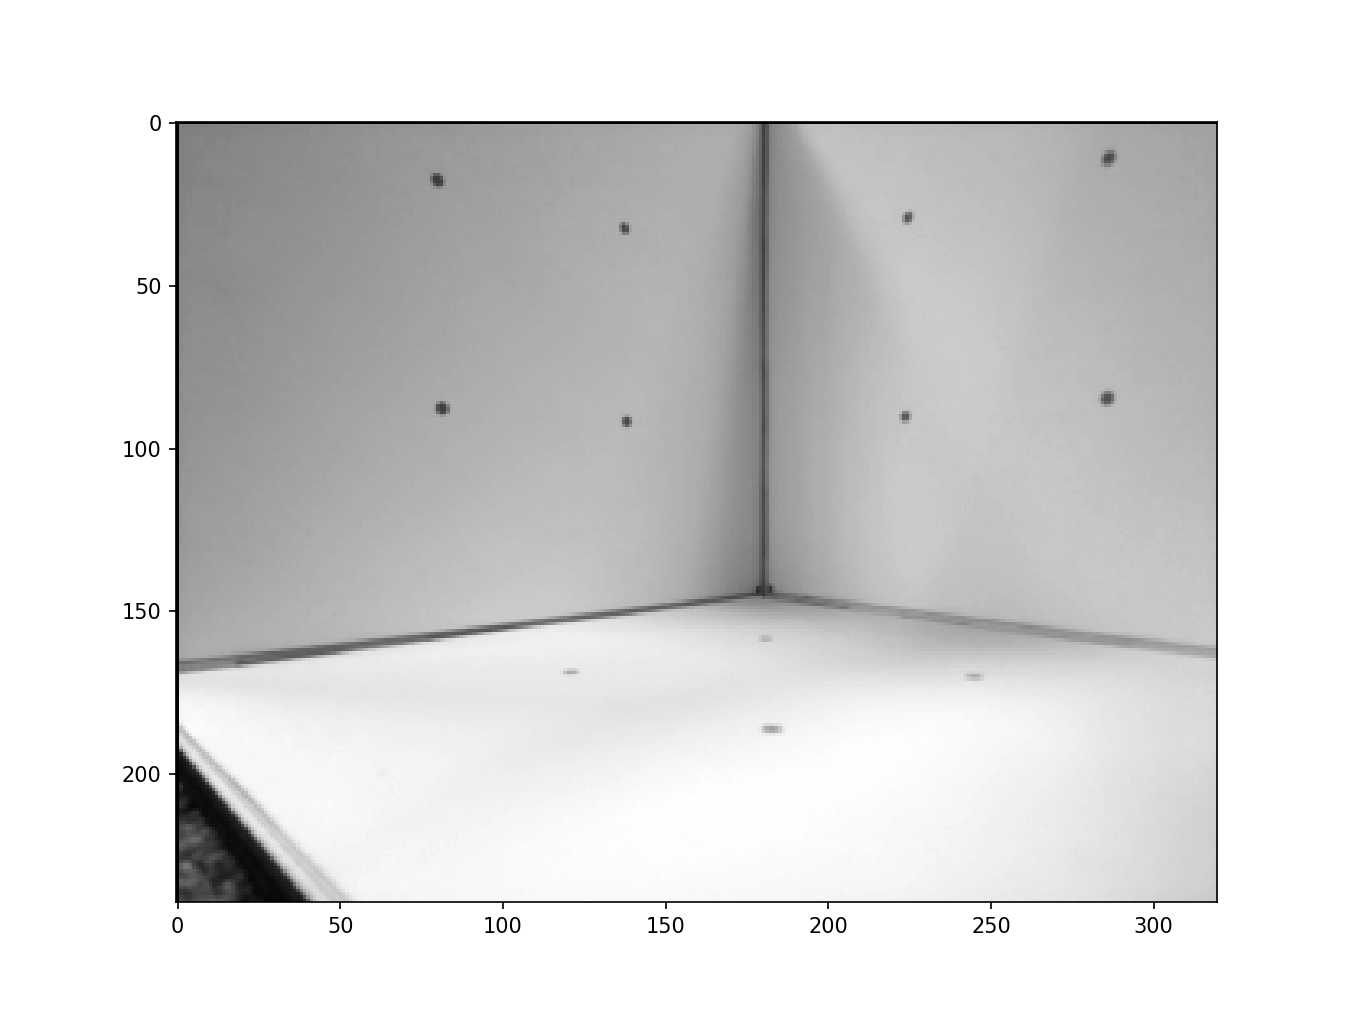

Textarea(value='[[      -1       -1]\n [      -1       -1]\n [      -1       -1]\n [      -1       -1]\n [    …

In [8]:
# Display image
image = Image('images/calib-image.png', grey=True)
fig = matplotlib.pyplot.figure()
plt.imshow(image.image, cmap='gray')

# Variables, p will contains clicked points, idx contains current point that is being selected
p = np.ones((8,2)) * -1
idx = 0

# Create text area widget to display clicked locations
txt = wdg.Textarea(value=str(p), placeholder='', description='Clicked Point:', disabled=False)
display(txt)

# Code to pick points and display in text widget
def onclick(event):
    global p, idx
    
#     txt.value = str(event)
    if event.button == 1:
        # left mouse click, add point and increment by 1
        p[idx, 0] = event.xdata
        p[idx, 1] = event.ydata
        idx = idx + 1
    elif event.button == 3:
        # right click, go back to previous point
        idx -= 1
        p[idx, 0] = -1
        p[idx, 1] = -1
        
    txt.value = str(p) 
    idx = np.min(np.max(idx, 0), 7) # to keep within bounds
    
ka = fig.canvas.mpl_connect('button_press_event', onclick)


In [9]:
p = p.T # we actually need a 2 x 8 matrix for the function below, so simply take the transpose
print(p)

[[   80.38    137.6    80.84    138.5    224.7    286.9    224.2    286.9]
 [   16.82    33.42    88.29    91.98    29.73    11.29    90.59    85.06]]


Now estimate the camera matrix, and extract the intrinsic and extrinsic parameters.  Compute the homography and see if you can sensibly map points between image plane and ground plane.

**Once you have the camera intrinsic matrix K, revist the Aruco marker exercise from A1 using the proper value of K, and see if the estimates of marker pose agree with what you can measure**

In [10]:
c = CentralCamera.camcal(P_calib,p)
camera = CentralCamera.invcamcal(c)
print(camera.K)

residual is 1.01 px
[[       1        0        0]
 [       0        1        0]
 [       0        0        1]]
[[   237.5        0    166.2]
 [       0    235.5    117.4]
 [       0        0        1]]
